In [8]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Importing

In [9]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), # mean and sd, calculated in ch7
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified


Files already downloaded and verified


# Basics

In [10]:
conv = nn.Conv2d(3, 16, kernel_size=3) # channels in, channels out
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

The shape of the weight tensor is (`out_ch`, `in_ch`, 3, 3); the kernel size is 3x3. For each pixel, we have to consider `in_ch=3` channels (r, g, b) and output `out_ch=16` channels.

The bias is just a constant added to each channel of the output

In [11]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [12]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

So, we have lost 2 pixels on x and y due to no padding, and we now have 16 channels. With padding:

In [13]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

# Feature detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


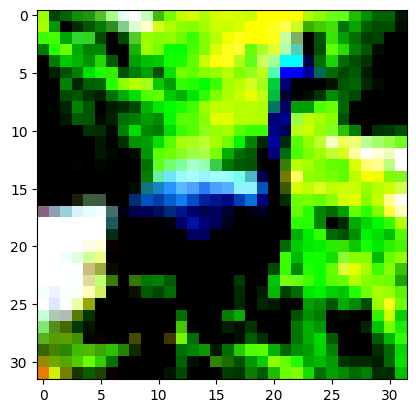

In [14]:
# Original:
plt.imshow(img.permute((1,2,0)), cmap='gray')
plt.show()

We can perform averaging using a constant kernel:

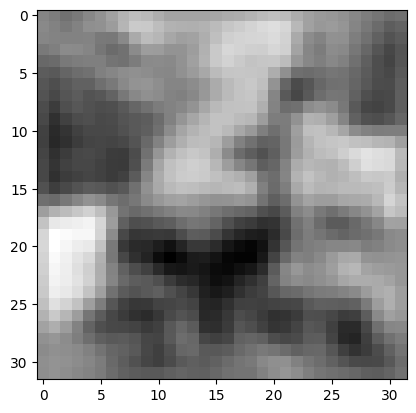

In [15]:
with torch.no_grad():
    conv.bias.zero_()

    conv.weight.fill_(1./9.)

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

We can do edge detection using the following kernel:

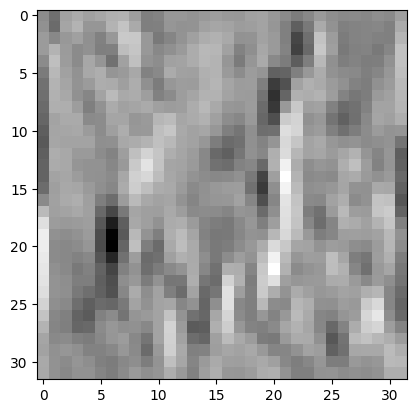

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()


# Pooling

There are several methods to downsample images, the most popular is max pooling, where we take the max in a grid:

In [17]:
pool = nn.MaxPool2d(2) # 2x2 pool
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

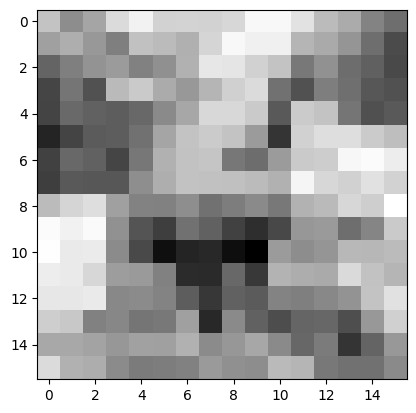

In [18]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()


By repeatedly performing convolutions and downsampling, our model can analyse small- and large-scale features

# Building a model

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # going from 3 channels to 16
    nn.Tanh(),
    nn.MaxPool2d(2), # reducing to 16x16
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # going from 16 channels to 8
    nn.Tanh(),
    nn.MaxPool2d(2)
    # etc etc
)

For better readability, we can subclass `nn.Module`. This also allows us to reshape the tensor properly before the final layers

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # going from 3 channels to 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        # reducing to 16x16
        self.pool1 = nn.MaxPool2d(2)

        # going from 16 channels to 8
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        # reducing to 8x8
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x: torch.Tensor):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # flatterns all dimensions
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out



In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

This is fine, but some of the layers, such as the `Tanh` and `MaxPool2d` have pre-set behaviour; they are not trained. We say they are **functional**:

In [22]:
import torch.nn.functional as F
 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.2490, -0.0652]], grad_fn=<AddmmBackward0>)

# Training

In [24]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.

        for imgs, labels in train_loader:

            # feed data through model
            outputs = model(imgs)

            # calculate loss
            loss = loss_fn(outputs, labels)

            # remove gradients from last round
            optimizer.zero_grad()

            # compute gradients of all parameters we are trying to learn
            loss.backward()

            # update the model
            optimizer.step()

            # sum all the losses over the epoch
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            # display average loss per batch
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))      



In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

mode = Net()

optimizer =optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)


2023-10-03 20:08:44.396064 Epoch 1, Training loss 0.5591235401903748
2023-10-03 20:09:51.909690 Epoch 10, Training loss 0.3259571762221634
2023-10-03 20:10:44.728834 Epoch 20, Training loss 0.29414110730408105
2023-10-03 20:11:25.981063 Epoch 30, Training loss 0.27236056242399154


KeyboardInterrupt: 

# Measuring accuracy

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:

        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest value
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)


Accuracy train: 0.93
Accuracy val: 0.89


# Saving

In [ ]:
torch.save(model.state_dict(), "birds_vs_aeroplanes.pt")

In [ ]:
loaded_model = Net()

loaded_model.load_state_dict(torch.load("birds_vs_aeroplanes.pt"))

<All keys matched successfully>

# GPU Training

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [ ]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.

        for imgs, labels in train_loader:
            
            # set device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # feed data through model
            outputs = model(imgs)

            # calculate loss
            loss = loss_fn(outputs, labels)

            # remove gradients from last round
            optimizer.zero_grad()

            # compute gradients of all parameters we are trying to learn
            loss.backward()

            # update the model
            optimizer.step()

            # sum all the losses over the epoch
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            # display average loss per batch
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:

        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest value
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

# validate(model, train_loader, val_loader)

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [ ]:

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
 
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# Regularization

To help the model converge and generalize better, it helps to keep the weights small, so we can add a regularization term to the weights, by computing their L2 or L1 norm.

L2 regularization is called **weight decay**, as the weights decrease by an amount proportional to themselves

## Dropout

We zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration.

We can implement dropout in a model by adding an `nn.Dropout` module between the nonlinear activation function and the linear or convolutional module of the subsequent layer.

Dropout gets eliminated when we are predicting from a trained model

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()

        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

drop_model = NetDropout().to(device=device)

optimizer = optim.SGD(drop_model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=drop_model,
    loss_fn=loss_fn,
    train_loader=train_loader
)


2023-08-30 16:31:27.970526 Epoch 1, Training loss 0.6981324105505731
2023-08-30 16:32:19.554840 Epoch 10, Training loss 0.6972904497650778
2023-08-30 16:33:16.245635 Epoch 20, Training loss 0.6983117286566716
2023-08-30 16:34:15.089384 Epoch 30, Training loss 0.6966154689242126
2023-08-30 16:35:10.652337 Epoch 40, Training loss 0.6973643367457542
2023-08-30 16:36:08.826972 Epoch 50, Training loss 0.6972533248032734
2023-08-30 16:37:06.261626 Epoch 60, Training loss 0.6974533712787993
2023-08-30 16:38:04.922057 Epoch 70, Training loss 0.6984811975697803
2023-08-30 16:39:02.261386 Epoch 80, Training loss 0.6967300935915322
2023-08-30 16:39:57.257142 Epoch 90, Training loss 0.6980876706208393
2023-08-30 16:40:54.186462 Epoch 100, Training loss 0.6976979913984894


In [ ]:
validate(mode, train_loader, val_loader)

Accuracy train: 0.57
Accuracy val: 0.57


## Batch normalization

The main idea behind batch normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution.

This means that activation functions are less likely to be saturated.

Batch normalization shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch.

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

bn_model = NetBatchNorm().to(device=device)

optimizer = optim.SGD(bn_model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=bn_model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

In [ ]:
validate(bn_model, train_loader, val_loader)

NameError: name 'validate' is not defined

## Skip connections

Deep models often have problems converging due to lots of successive multiplications leading to some numbers dominating. Hence, we can introduce skip layers:

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # add contribution from layer before
        out1 = out        
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

NameError: name 'nn' is not defined

## Blocks

For very deep nets, it can be helpful to abstract into blocks (like a Conv, BatchNorm, ReLU, skip connection):

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        # ititialises with random elements, sd taken from ResNet paper.
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
 
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [ ]:
class DeepResNet(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
